In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
from manipulations import get_Datas
datasets = [1,2,3,4,5,6]
_, Codes, dataset_data_labels, dataset_train_idx, dataset_test_idx = get_Datas(datasets)

Dataset  1


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.
Dataset  2



Done.
Dataset  3


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  4


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  5


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.
Dataset  6


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.


In [7]:
from saved_data_io import read_file
data_imgs2 = []
for dataset in tqdm(datasets):
    data_imgs = read_file('data_imgs_dataset{}'.format(dataset))
    print(len(data_imgs))
    data_imgs2 += data_imgs

read from ../saved/data_imgs_dataset1.pkl
6877
read from ../saved/data_imgs_dataset2.pkl
3453
read from ../saved/data_imgs_dataset3.pkl
74
read from ../saved/data_imgs_dataset4.pkl
516
read from ../saved/data_imgs_dataset5.pkl
21837
read from ../saved/data_imgs_dataset6.pkl
10344



In [8]:
assert len(data_imgs2) == len(Codes)

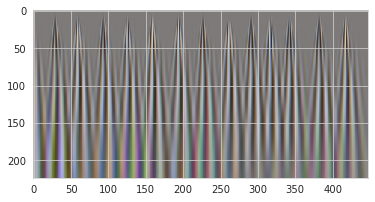

In [9]:
plt.imshow(data_imgs2[5][3])

In [11]:
from manipulations import get_scored_class
from global_vars import labels
# n_segments = 11
# def crop_imgs(data_img, n_segments = n_segments, vis = False):
    
#     shift_len = int((data_img[0].size[0]-224) / (n_segments-1))
#     if vis:
#         plt.imshow(data_img)
#         plt.show()
        
#     # each imgs
#     imgs = []
#     for i in range(n_segments):
        
#         # each channel of each segment
#         img_chns = []
#         for chn in range(4):
#             img = data_img[chn].crop((i*shift_len,0,i*shift_len+224,224)) # 0, 0, 224, 224 left, upper, right, and lower
#             img_chns.append(img)
            
#             if vis:
#                 plt.imshow(img)
#                 plt.show()
                
#         imgs.append(img_chns)
#     return imgs

data_img2_labels = []
for i in tqdm(range(len(Codes))):
    data_img2_labels.append(get_scored_class(Codes[i], labels))

data_img2_labels = np.array(data_img2_labels)
assert len(data_img2_labels) == len(Codes)

In [12]:
# change to equivalent mapping
from global_vars import equivalent_mapping
key_idxes = []
for key in equivalent_mapping.keys():
    print(key)
    key_idx = np.argwhere(labels==int(key)).flatten()[0]
    key_idxes.append(key_idx)
    val_idx = np.argwhere(labels==int(equivalent_mapping[key])).flatten()[0]
    key_pos = np.argwhere(data_img2_labels[:,key_idx]==1).flatten()
    val_pos = np.argwhere(data_img2_labels[:,val_idx]==1).flatten()
    data_img2_labels[key_pos,val_idx] = 1
    data_img2_labels[val_pos,key_idx] = 1

713427006
284470004
427172004


In [18]:
#dataset_train_idx[2n]
train_idx = []
test_idx = []
for dataset in datasets:
    for idx in dataset_train_idx[dataset]:
        train_idx.append(idx)
    for idx in dataset_test_idx[dataset]:
        test_idx.append(idx)
    
assert len(train_idx)+len(test_idx) == len(Codes)

In [20]:
from torch.utils.data import Dataset
from torchvision import transforms
from global_vars import labels
from manipulations import get_name
import os
class MyImageMultichannelDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, channel_imgs, manyhot_encoding_labels, class_idx, transform):
        """
                
        channel_imgs = chn -> array of PImage
        """
        self.manyhot_encoding_labels = manyhot_encoding_labels
        self.channel_imgs = channel_imgs
        self.transform = transform

    def __len__(self):
        return len(self.manyhot_encoding_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [self.channel_imgs[idx][chn] for chn in range(4)]
        manyhot_encoding_label = self.manyhot_encoding_labels[idx]
        sample =(torch.cat([self.transform(image) for image in images],0), 
                 torch.Tensor(manyhot_encoding_label[class_idx]))

        return sample

from global_vars import labels, Dx_map, Dx_map_unscored, equivalent_mapping
names = [get_name(label, Dx_map, Dx_map_unscored) for label in labels]
class_idx = np.argwhere(np.sum(np.array(data_img2_labels)[train_idx],axis=0)!=0).flatten() 
names = np.array(names)[class_idx]

print("len(class_idx)", len(class_idx))



len(class_idx) 27


In [21]:
data_imgs2[0]

[<PIL.Image.Image image mode=RGB size=448x224 at 0x7FE198E80908>,
 <PIL.Image.Image image mode=RGB size=448x224 at 0x7FE198D03F98>,
 <PIL.Image.Image image mode=RGB size=448x224 at 0x7FE30ACFE5F8>,
 <PIL.Image.Image image mode=RGB size=448x224 at 0x7FE2C2B9DCC0>]

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [24]:
from torch import nn
from torchvision import models
    
class MultiCWTNet(nn.Module):
    def __init__(self, n_classes, verbose=False):
        super(MultiCWTNet, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = self.increase_channels(self.resnet.conv1, num_channels=12, copy_weights=0)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

        self.verbose = verbose
        
    def forward(self, xs):
        x = self.resnet(xs)
        return x
    
    
    def increase_channels(self, m, num_channels=None, copy_weights=0):
        """
        https://github.com/akashpalrecha/Resnet-multichannel/blob/master/multichannel_resnet.py
        
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        
        copy_weights (int): copy the weights of the channel (int)
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=False)
        
        # Copying the weights from the old to the new layer
        new_m.weight[:, :m.in_channels, :, :] = m.weight.clone()
        
        #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
        for i in range(new_in_channels - m.in_channels): # 12 - 3
            channel = m.in_channels + i # 3，4，5，6，7，8，9，10，11
            new_m.weight[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
        new_m.weight = nn.Parameter(new_m.weight)

        return new_m

In [ ]:
from torchvision import datasets, models, transforms
import torch
torch.manual_seed(0)
from myeval import agg_y_preds_bags, binary_acc, geometry_loss, compute_score
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
import time
from pytorch_training import add_pr_curve_tensorboard
from imbalanced_sampler import  WeightedImbalancedDatasetSampler
from torch.utils.tensorboard import SummaryWriter

st = time.time()
patience = 50
batch_size= 64#65000
from global_vars import normal_class
normal_idx = np.argwhere(names==int(normal_class))
run_name = 'modelMultiCWTFull_ALL_randomCrop_seed0'
writer = SummaryWriter('runs/{}'.format(run_name))

from global_vars import weights


from imbalanced_weights import cal_multilabel_weights, inverse_weight
sample_weights, Data_labels_train_new, label_to_count, new_index_dict = cal_multilabel_weights(data_img2_labels[train_idx], 0)


data_transforms = {
    'train':  transforms.Compose([
                         transforms.RandomCrop(224),
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ]),  
     'test': transforms.Compose([
                         transforms.CenterCrop(224),
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])
    
}

image_datasets_train = MyImageMultichannelDataset(data_imgs2, data_img2_labels, class_idx, data_transforms['train'])
image_datasets_test = MyImageMultichannelDataset(data_imgs2, data_img2_labels, class_idx, data_transforms['test'])

trainDataset = torch.utils.data.Subset(image_datasets_train, train_idx)
testDataset = torch.utils.data.Subset(image_datasets_test, test_idx)

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, pin_memory=True, shuffle=True)
                                         # sampler=WeightedImbalancedDatasetSampler(trainDataset, weights=sample_weights))
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=300, shuffle = False, pin_memory=True)

#train_class_weight = torch.Tensor(inverse_weight(Data_labels_train, class_idx)).to(device)
#test_class_weight = torch.Tensor(inverse_weight(Data_labels_test, class_idx)).to(device)
criterion_train = nn.BCEWithLogitsLoss(reduction='mean')#, weight=train_class_weight) 
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')#, weight=test_class_weight) 

saved_dir = '../saved/modelMultiCWTFull2/'
early_stopping = EarlyStopping(patience, verbose=False, 
                              saved_dir=saved_dir, 
                              save_name=run_name)

model = MultiCWTNet(len(class_idx), verbose=False)
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.01) 
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
# Decay LR by a factor of 0.1 every 100 epochs
#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, mode='max')


y_trains_tensor = None
y_tests_tensor = None
losses_train = []
avg_losses_train = []
losses_test = []
avg_losses_test = []

for epoch in range(0, 5000):

    model.train()

    running_loss_train = 0.0

    y_trains = [] # ground truth
    output_trains = [] # output
    for k, (X_train, y_train) in tqdm(enumerate(trainLoader)):
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        optimizer.zero_grad()
        output_train = model(X_train)
        output_trains.append(output_train.cpu())
        
        loss_train = criterion_train(output_train, y_train)
        losses_train.append(loss_train.item())
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
    
        
        if np.mod(k, 100) == 0:
            writer.add_scalar('train/loss',
            avg_loss_train,
            epoch * (len(train_idx)//batch_size//100+1) + k//100)
        
        y_trains.append(y_train.cpu())
            
        loss_train.backward()
        optimizer.step()
            
    #scheduler.step()
    

    y_tests = [] # ground truth
    output_tests = [] # output
    with torch.no_grad():
        model.eval()
        
        for X_test, y_test in testLoader:  
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            output_test = model(X_test)

            loss_test = criterion_test(output_test, y_test)
            losses_test.append(loss_test.item())

            output_tests.append(output_test.cpu())
            y_tests.append(y_test.cpu())
            
            
            
        avg_loss_test = np.average(losses_test)
        avg_losses_test.append(avg_loss_test)

        writer.add_scalar('test/loss',
                avg_loss_test,
                epoch)



    y_trains_tensor = torch.cat(y_trains, axis=0) # ground truth
    y_tests_tensor = torch.cat(y_tests, axis=0) # ground truth

    output_trains = torch.cat(output_trains, axis=0) 
    y_train_preds = torch.sigmoid(output_trains)

    output_tests = torch.cat(output_tests, axis=0)
    y_test_preds = torch.sigmoid(output_tests)

    #output_trains = torch.cat(output_trains, axis=0)
#     y_train_preds_max, y_train_preds_mean, _ = agg_y_preds_bags(y_train_preds, bag_size=n_segments)
#     y_test_preds_max, y_test_preds_mean, _ = agg_y_preds_bags(y_test_preds, bag_size=n_segments)
#     _, _, y_trains = agg_y_preds_bags(y_trains, bag_size=n_segments)
#     _, _, y_tests = agg_y_preds_bags(y_tests, bag_size=n_segments)


    for class_i_idx in range(len(class_idx)):
        add_pr_curve_tensorboard(writer, class_i_idx, y_trains_tensor, y_train_preds, names, global_step=epoch, prefix='train/')
        add_pr_curve_tensorboard(writer, class_i_idx, y_tests_tensor, y_test_preds, names, global_step=epoch, prefix='test/')



    acc, fmeasure, fbeta, gbeta = binary_acc(y_train_preds, y_trains_tensor)           
    acc2, fmeasure2, fbeta2, gbeta2 = binary_acc(y_test_preds, y_tests_tensor)
    geometry = geometry_loss(fbeta, gbeta)
    geometry2 = geometry_loss(fbeta2, gbeta2)
    
#     output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
#         epoch, (time.time()-st)/60,
#         avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, np.nan,
#         avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, np.nan)
#     print(output_str)
    score = compute_score(np.round(y_train_preds.data.numpy()), np.round(y_trains_tensor.data.numpy()),  weights, class_idx, normal_idx)
    score2 = compute_score(np.round(y_test_preds.data.numpy()), np.round(y_tests_tensor.data.numpy()), weights, class_idx, normal_idx)
    output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
        epoch, (time.time()-st)/60,
        avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, score,
        avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, score2)
    scheduler.step(score2)
    
    writer.add_scalar('train/score',
            score,
            epoch)
    writer.add_scalar('train/gbeta',
            gbeta,
            epoch)
    writer.add_scalar('train/fbeta',
            fbeta,
            epoch)
    writer.add_scalar('train/geometry',
            geometry,
            epoch)
    
    writer.add_scalar('test/score',
            score2,
            epoch)
    writer.add_scalar('test/gbeta',
            gbeta2,
            epoch)
    writer.add_scalar('test/fbeta',
            fbeta2,
            epoch)
    writer.add_scalar('test/geometry',
            geometry2,
            epoch)
    
    print(output_str)

    with open(saved_dir+'loss_{}.txt'.format(run_name), 'a') as f:
        print(output_str, file=f)

    early_stopping(-score2, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


#     output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure|Geomotry\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2,geometry2)
#     print(output_string)     
#     with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
#         f.write(output_string)

#     avg_losses_train = np.array(avg_losses_train)
#     avg_losses_test = np.array(avg_losses_test)

#     np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
#     np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
